# Import needed libaries

In [27]:
import numpy as np
import struct
from array import array
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.interpolate import splprep, splev
from geomdl import NURBS
from geomdl import utilities

# Import MNIST Dataset

In [ ]:
# https://www.kaggle.com/code/hojjatk/read-mnist-dataset

# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
    
        # Convert lists to NumPy arrays
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)

        return (x_train, y_train), (x_test, y_test)


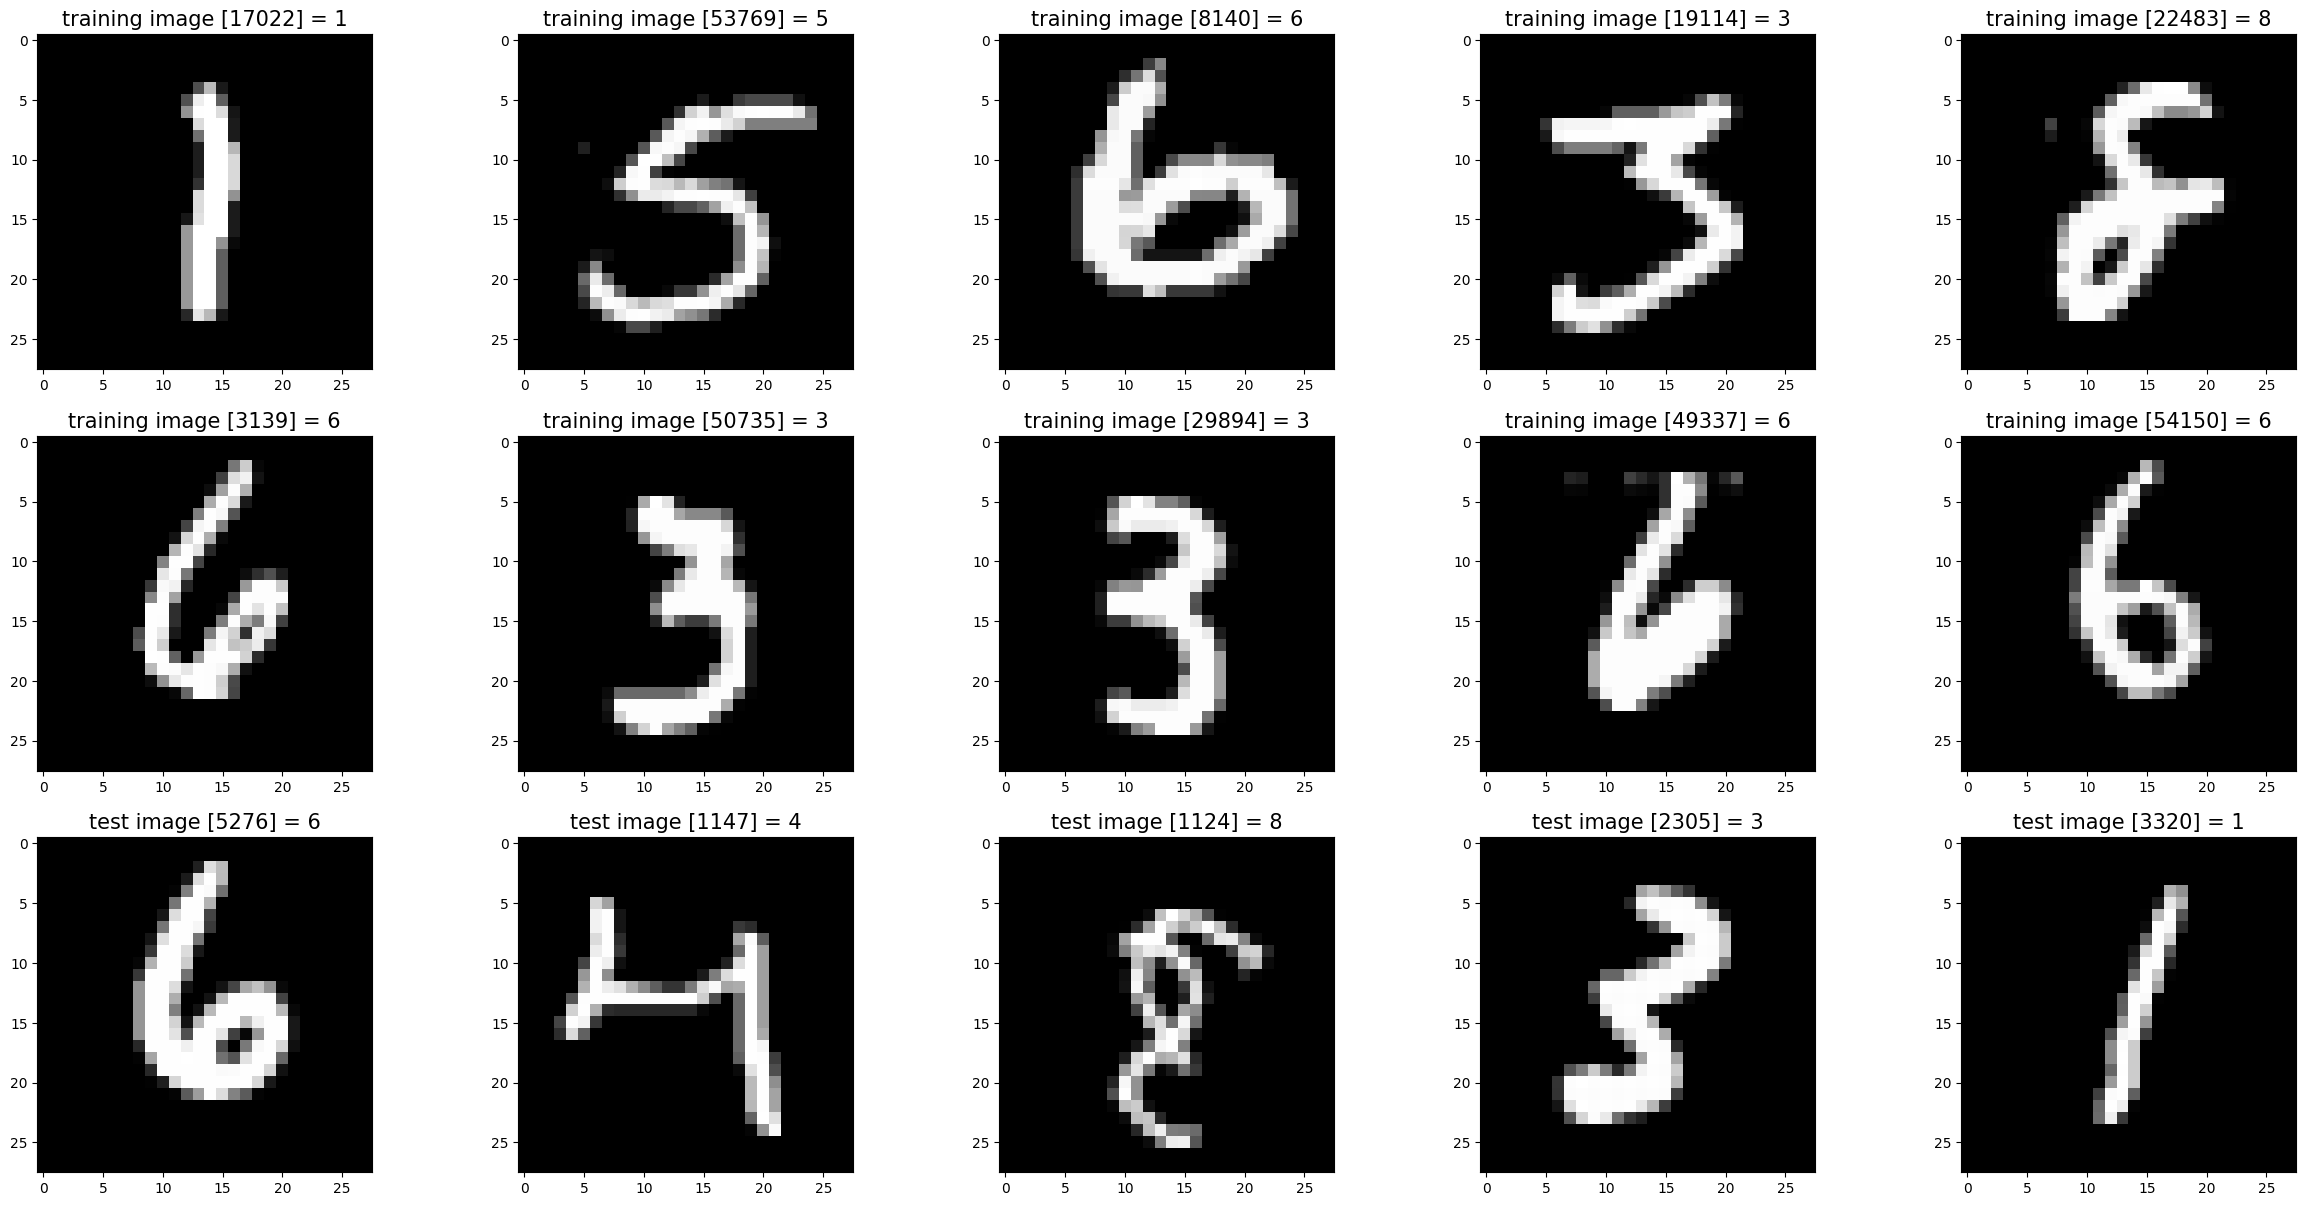

In [ ]:
# Set file paths based on added MNIST Datasets
training_images_filepath = ('train_images.idx3-ubyte')
training_labels_filepath = ('train_labels.idx1-ubyte')
test_images_filepath = ('test_images.idx3-ubyte')
test_labels_filepath = ('test_labels.idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Filter for just '1'

In [4]:
x_train_1 = x_train[y_train == 1]
y_train_1 = y_train[y_train == 1]

x_test_1 = x_test[y_test == 1]
y_test_1 = y_test[y_test == 1]

print(f"Number of training images labeled '1': {len(x_train_1)}")
print(f"Number of test images labeled '1': {len(x_test_1)}")

Number of training images labeled '1': 6742
Number of test images labeled '1': 1135


Image shape before reshape: (28, 28)


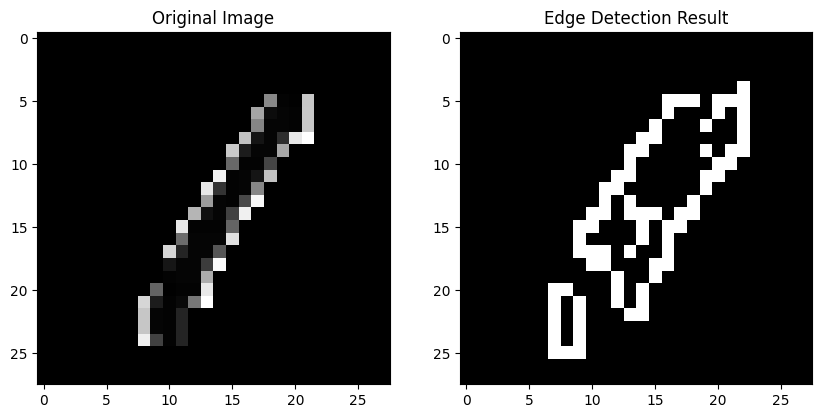

In [5]:
# Select one image of digit '1'
image = x_train_1[0]  # Select first filtered '1' image

print("Image shape before reshape:", image.shape)


# Ensure the image has the correct shape (28x28 for MNIST)
if len(image.shape) != 2:
    image = image.reshape(28, 28)

# Ensure the image is in uint8 format
image = (image * 255).astype(np.uint8)

# Apply Gaussian Blur (reduces noise)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply Canny Edge Detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Display Original Image and Edge Detected Image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection Result")

plt.show()

# SciPy Implementation

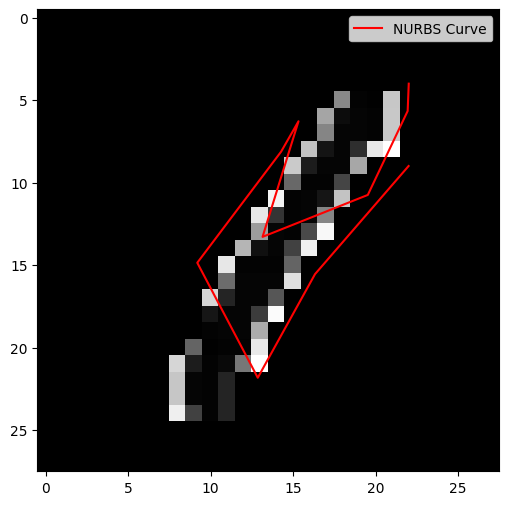

In [26]:
# Select one image of digit '1'
image = x_train_1[0]  # Select the first filtered '1' image

# Convert to uint8 (needed for OpenCV)
image = (image * 255).astype(np.uint8)

# Apply Gaussian Blur (optional, reduces noise)
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Apply Canny Edge Detection
edges = cv2.Canny(blurred, threshold1=5, threshold2=5)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the largest contour
contour = max(contours, key=cv2.contourArea)

# Convert contour points to a format suitable for interpolation
contour = contour[:, 0, :]  # Remove unnecessary dimension
x, y = contour[:, 0], contour[:, 1]

# Fit a NURBS curve (B-spline approximation)
tck, u = splprep([x, y], s=2)  # s controls smoothness
u_new = np.linspace(0, 1, 10)  # Generate 10 points along the curve
x_smooth, y_smooth = splev(u_new, tck)

# Plot results
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.plot(x_smooth, y_smooth, 'r-', label='NURBS Curve')  # Red curve
plt.legend()
plt.show()

In [25]:
pip install geomdl


  Obtaining dependency information for geomdl from https://files.pythonhosted.org/packages/48/32/559b938e6654ecdf87d256ac2bfd9a25464560a312a58aaf25076d0ce48e/geomdl-5.3.1-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/147.6 kB ? eta -:--:--
   -- ------------------------------------- 10.2/147.6 kB ? eta -:--:--
   -------- ------------------------------ 30.7/147.6 kB 330.3 kB/s eta 0:00:01
   ------------------------ -------------- 92.2/147.6 kB 655.4 kB/s eta 0:00:01
   -------------------------------------- 147.6/147.6 kB 980.9 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
